In [1]:
# Import the different module we will need in this notebook
import os
import cv2
# To read and compute on Images: imageio [imageio doc](https://imageio.readthedocs.io/en/stable/)
# To create some plot and figures: matplolib [matplotlib doc](https://matplotlib.org/)
# To do computation on matrix and vectors: numpy [numpy doc](https://numpy.org/)
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# To do computation on matrix and vectors and automatic differenciation: pytorch [torch doc](https://pytorch.org/docs/stable/index.html)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

# To do some computation on images with pytorch direclty on the GPU [torchvision doc](https://pytorch.org/vision)

import random
import tqdm.notebook as tq


# Loading data

In [2]:
Download = True #@param {type:"boolean"}

if Download:
  !gdown "https://drive.google.com/uc?id=1x0JdeA2Mo_QvYIJDHMfempoy2R675gMi" -O "birds_eye_data.zip"
else:
  !cp '/content/drive/My Drive/Self Driving/birds_eye_data_final.zip' 'birds_eye_data.zip' 

!unzip 'birds_eye_data.zip'

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/right/40170.npy    
  inflating: data/right/32064.npy    
  inflating: data/right/36996.npy    
  inflating: data/right/36932.npy    
  inflating: data/right/20050.npy    
  inflating: data/right/15450.npy    
  inflating: data/right/22703.npy    
  inflating: data/right/11843.npy    
  inflating: data/right/24417.npy    
  inflating: data/right/26061.npy    
  inflating: data/right/41115.npy    
  inflating: data/right/32412.npy    
  inflating: data/right/428.npy      
  inflating: data/right/8140.npy     
  inflating: data/right/20966.npy    
  inflating: data/right/30368.npy    
  inflating: data/right/45622.npy    
  inflating: data/right/4634.npy     
  inflating: data/right/16072.npy    
  inflating: data/right/40601.npy    
  inflating: data/right/18667.npy    
  inflating: data/right/44578.npy    
  inflating: data/right/45098.npy    
  inflating: data/right/5655.npy     
  inflatin

In [3]:
def plot_cameras(sequence_number):

  rows = 2
  columns = 3
  fig=plt.figure(figsize=(10, 10))
  imgs = []
  cameras = ['left', 'front','right', 'back','top']
  
  for i, camera in enumerate(cameras):
    sample = np.load(f"./data/{camera}/{sequence_number}.npy")
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(sample, cmap='gist_stern')

  plt.show()



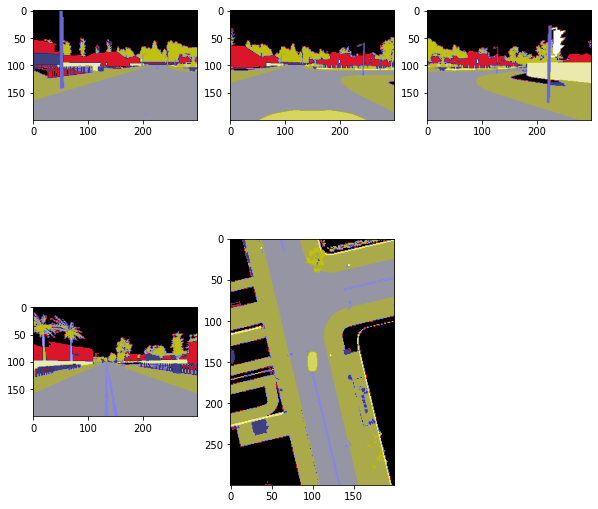

In [4]:
plot_cameras(100)

In [5]:
import os

def get_paths(val_size=5000):

  img_paths = []

  for i in range(len(os.listdir('./data/top'))):
    path = f'{i}.npy'
    img_paths.append(path)

  return pd.DataFrame({'path':img_paths[:-val_size]}), pd.DataFrame({'path':img_paths[-val_size:]})

In [6]:
img_paths_train, img_paths_val = get_paths()

In [7]:
img_paths_train

,path
0,0.npy
1,1.npy
2,2.npy
3,3.npy
4,4.npy
...,...
40995,40995.npy
40996,40996.npy
40997,40997.npy
40998,40998.npy


In [8]:
img_paths_val

,path
0,41000.npy
1,41001.npy
2,41002.npy
3,41003.npy
4,41004.npy
...,...
4995,45995.npy
4996,45996.npy
4997,45997.npy
4998,45998.npy


## Setting up Data Generators

In [9]:
def img_to_categorical(img, needed_labels):
  
  cat = np.empty((img.shape[0], img.shape[1], len(needed_labels)))

  for channel, label in enumerate(needed_labels):
    cat[:, :, channel] = np.where(np.isin(img, label), 1, 0)

  return cat

def categorical_to_img(cat):
  
  cat = np.argmax(cat, axis=-1)
  return cat

needed_labels = [0, 1, 6, 7, 8, 10, 11]
#needed_labels = [0, 1, 6, 7]

In [44]:
import random
import numpy as np
import cv2
import torch
import torchvision

# custom augmentation functions
#from image_augmentation import *

class PytorchDataGenerator(torch.utils.data.Dataset):
    def __init__(self, img_paths, base_path, to_fit=True, batch_size=32, shuffle=True, needed_classes = []):
    
        self.img_paths = img_paths.copy()
        self.base_path = base_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.needed_classes = needed_classes
        self.on_epoch_end()
    
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(len(self.img_paths) // self.batch_size)

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        current_indexes = list(range(index * self.batch_size, (index + 1) * self.batch_size))
        img_paths_temp = self.img_paths[current_indexes]

        # Generate data
        X = self._generate_X(img_paths_temp)
        X = self._transformation(X)
        if self.to_fit:
            y = self._generate_y(img_paths_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.shuffle == True:
            indices = np.arange(len(self.img_paths))
            np.random.shuffle(indices)
            self.img_paths = self.img_paths[indices]
            self.img_paths.reset_index(drop=True, inplace=True)


    def _generate_X(self, img_paths_temp):
        """Generates data containing batch_size images
        :param img_paths_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization

        X = []

        # Generate data
        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path)
            X.append(img)
        return np.array(X)

    def _generate_y(self, img_paths_temp):

        y = []

        for idx, path in zip(img_paths_temp.index, img_paths_temp):
            # Store sample
            img = self._load_image(path, front=False)
            y.append(img) 
        return np.array(y)

    def _load_image(self, image_path, front=True):
      
        if front:
          img_dir =  '/front/'
        else:
          img_dir =  '/top/'

        img = np.load(self.base_path + img_dir + image_path)
        img = img[::2, ::2]                                          # Downsampling image by factor of 2

        if not front:
          img = img[3:(img.shape[0]//2)]
          img = np.rot90(img)
          img = img[2:-2]                                           # Crop Image to make dimensions divisible by 8 
          img = img_to_categorical(img, self.needed_classes)

          return img
          
        img = img[2:-2, 3:-3]                                       # Crop Image to make dimensions divisible by 8 
        img = img_to_categorical(img, self.needed_classes)

        return img

    def _transformation(self,X):
        #img_tensor = []
        #X = torch.tensor(X)
        #for i in range (0,len(X)):
          #X[i] = torch.tensor(X[i]).float()
          #print(type(X[i]))
          #print(X[i].shape)
          #X[i] = X[i].unsqueeze(0)
          #print(X[i].shape)
          #X[i].permute(0,3,1,2)
          #X[i].cuda
        #X = torch.tensor(X).float()
        #X = X.permute(0,3,1,2)
        #X.cuda
        return X

            #img_tensor.append(torch.tensor(X[i]).float())
            #print(img_tensor[i].shape)
            #img_tensor[i] = img_tensor[i].unsqueeze(0)
            #print(img_tensor[i].shape)
            #img_tensor[i].permute(0,3,1,2)
            #img_tensor[i].cuda()
        #return img_tensor


In [45]:
train_generator = PytorchDataGenerator(img_paths_train['path'], './data', batch_size=32, shuffle=True, needed_classes=needed_labels)
val_generator = PytorchDataGenerator(img_paths_val['path'], './data', batch_size=1, shuffle=False, needed_classes=needed_labels)

In [46]:
X, y = train_generator.__getitem__(0)
print(X.shape, y.shape)
z = train_generator.__len__()
print(z)

(32, 96, 144, 7) (32, 96, 72, 7)
1281


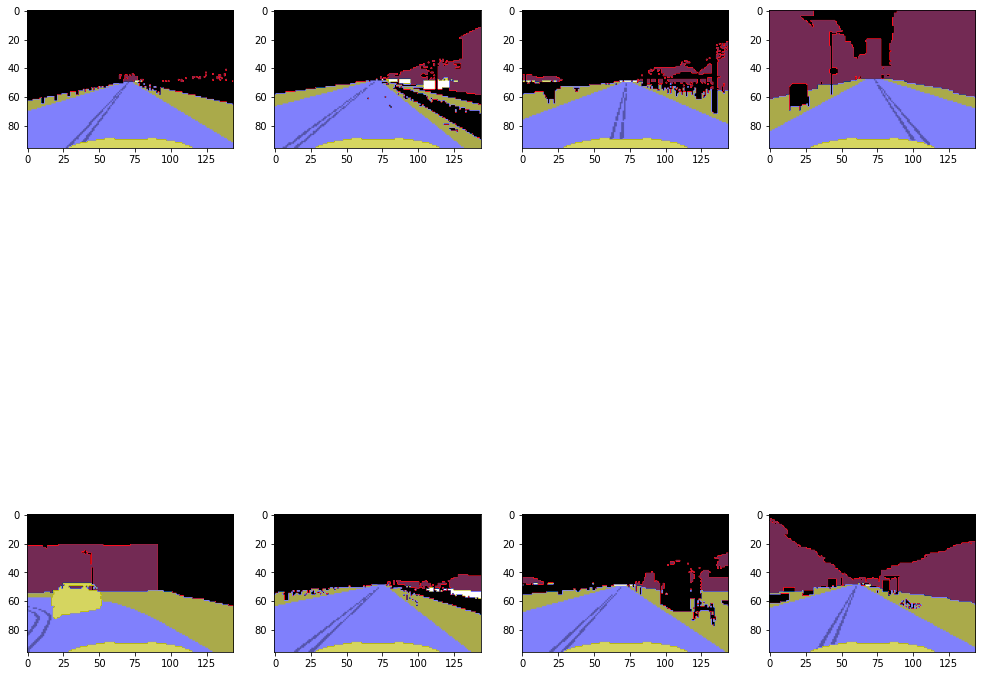

In [13]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = X[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(categorical_to_img(img), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()



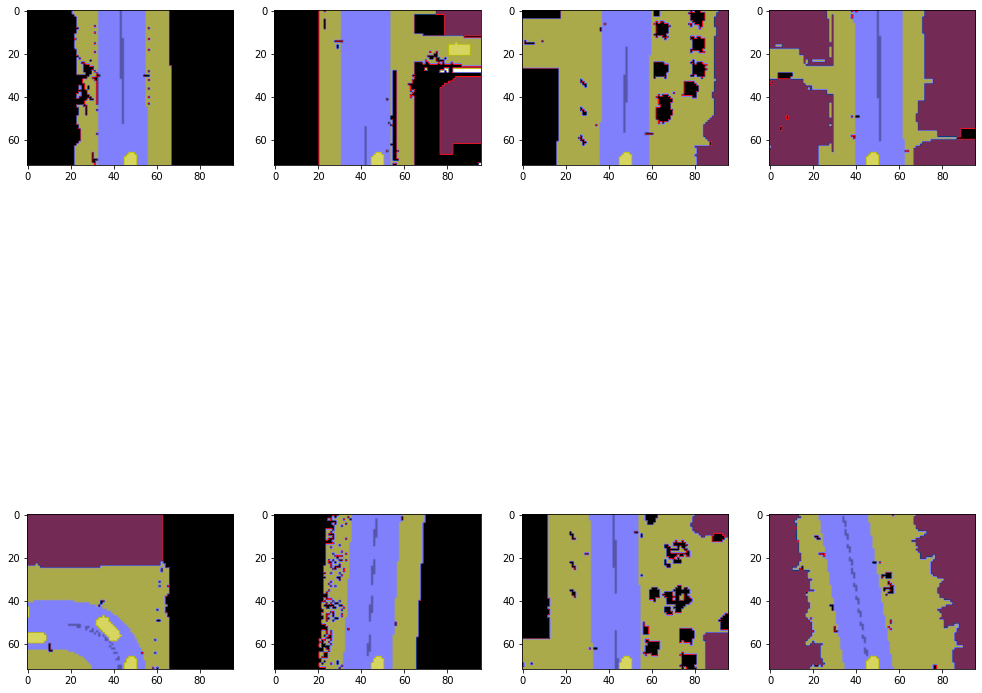

In [14]:
fig=plt.figure(figsize=(17, 17))
columns = 4
rows = 2
for i in range(1, columns*rows + 1):
    img = y[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.rot90(categorical_to_img(img), 3), cmap='gist_stern', vmin=0, vmax=len(needed_labels)-1)
plt.show()

# AutoEncoder

In [15]:
from math import *
def padding_same(output_dim,input_dim, kernel, stride):
  return ceil((output_dim-((input_dim-kernel)/stride+1)*stride/2))
print(padding_same(6,6,3,1))

4


In [76]:
from torchvision import models
from torchsummary import summary
class get_model(nn.Module):
    def __init__(self, classes=10):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(7, 32, kernel_size=5, padding=[padding_same(48,96,5,2),padding_same(72,144,5,2)], stride = 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=[padding_same(24,48,5,2),padding_same(36,72,5,2)], stride = 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=[padding_same(12,24,3,2),padding_same(18,36,3,2)], stride = 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=[padding_same(6,12,3,2),padding_same(9,18,3,2)], stride = 2),
            nn.BatchNorm2d(128),
            nn.LeakyReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer7 = nn.Sequential(
            nn.Upsample(scale_factor  = (2,2)),
            nn.Conv2d(256, 256, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer8 = nn.Sequential(
            nn.Upsample(scale_factor  = (2,2)),
            nn.Conv2d(256, 128, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer9 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer10 = nn.Sequential(
            nn.Upsample(scale_factor  = (2,2)),
            nn.Conv2d(128, 64, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer11 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=(1,1), stride = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        self.layer12 = nn.Sequential(
            nn.Upsample(scale_factor = (2,1)),
            nn.Conv2d(32, 32, kernel_size=5, padding=(2,2), stride = 1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2,inplace=True))
        #last layer
        self.layer13 = nn.Sequential(
            nn.Conv2d(32, 7, kernel_size=5, padding=(2,2), stride = 1),
            nn.Softmax()
        )
    def forward(self, x):
      print("forward shape entry")
      print(x.shape)
      out = self.layer1(x).to(device)
      print("forward1")
      print(out.shape)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      out = self.layer6(out)
      out = self.layer7(out)
      out = self.layer8(out)
      out = self.layer9(out)
      out = self.layer10(out)
      out = self.layer11(out)
      out = self.layer12(out)
      out = self.layer13(out)
      print('out forward', out.shape)
      return out

def train_one_epoch(model, device, data_loader, optimizer):
    train_loss = 0
    correct = 0
    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader)/data_loader.batch_size):
        data = torch.tensor(data)
        target = torch.tensor(target)
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        
       
        data = data.permute(0,3,1,2)
        data = data.float()
        print("hello")
        print(data.shape)
        data = data.float()
        output = model(data)

        
        
        
        target = target.squeeze(0)
        
        target = target.permute(0,3,1,2)
        print(output.shape,target.shape)
        loss = nn.CrossEntropyLoss()
        loss = loss(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()

    result = {'loss': train_loss / len(data_loader),
              'accuracy': correct / len(data_loader)
              }
    return result   
 
def evaluation(model, device, data_loader):
    eval_loss = 0
    correct = 0

    for num, (data, target) in tq.tqdm(enumerate(data_loader), total=len(data_loader)/data_loader.batch_size):
        data = torch.tensor(data)
        target = torch.tensor(target)
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        print("shape")
        print(data.shape)
        #data = data.squeeze(1)
        
        print("shape 2")
        print(data.shape)
        data = data.float()
        data = data.permute(0,3,1,2)
        print("shape permute")
        print(data.shape)
        output = model(data)
        target = target.squeeze(0)
        eval_loss += F.cross_entropy(output, target).item()
        prediction = output.argmax(dim=1)
        correct += torch.sum(prediction.eq(target)).item()
    result = {'loss': eval_loss / len(data_loader),
              'accuracy': correct / len(data_loader)
              }
    return result
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#needed_labels_nump = np.array(needed_labels)
#needed_labels_torch = torch.from_numpy(needed_labels_nump)
#needed_labels_torch = needed_labels_torch.to(device)
model = get_model()
if torch.cuda.is_available():
    model.cuda()
#print(model)
summary(model,(7,96,144))


forward shape entry
torch.Size([2, 7, 96, 144])
forward1
torch.Size([2, 32, 48, 72])
out forward torch.Size([2, 7, 96, 72])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 72]           5,632
       BatchNorm2d-2           [-1, 32, 48, 72]              64
         LeakyReLU-3           [-1, 32, 48, 72]               0
            Conv2d-4           [-1, 64, 24, 36]          51,264
       BatchNorm2d-5           [-1, 64, 24, 36]             128
         LeakyReLU-6           [-1, 64, 24, 36]               0
            Conv2d-7          [-1, 128, 12, 18]          73,856
       BatchNorm2d-8          [-1, 128, 12, 18]             256
         LeakyReLU-9          [-1, 128, 12, 18]               0
           Conv2d-10            [-1, 128, 6, 9]         147,584
      BatchNorm2d-11            [-1, 128, 6, 9]             256
        LeakyReLU-12            [-1, 128, 6

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [28]:
model = get_model()


In [29]:
camera ='front'
sequence_number= 100

sample = np.load(f"./data/{camera}/{sequence_number}.npy")

sample

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7],
       [7, 7, 7, ..., 7, 7, 7]], dtype=uint8)

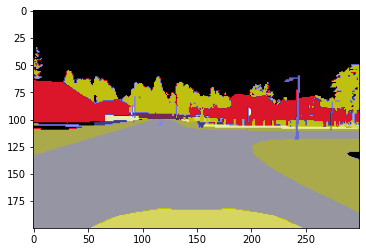

In [30]:
plt.imshow(sample, cmap='gist_stern')
plt.show()

In [31]:
type(sample)

numpy.ndarray

In [32]:
sample.shape

(200, 300)

In [50]:
device

device(type='cuda', index=0)

In [62]:
img_tensor = torch.tensor(X[0]).float()
print(img_tensor.shape)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)
img_tensor = img_tensor.permute(0,3,1,2)
#img_tensor.shape
img_tensor = img_tensor.to(device)

torch.Size([96, 144, 7])
torch.Size([1, 96, 144, 7])


In [63]:
ouput=model(img_tensor)
print(ouput.shape)

forward shape entry
torch.Size([1, 7, 96, 144])
forward1
torch.Size([1, 32, 48, 72])
out forward torch.Size([1, 7, 96, 72])
torch.Size([1, 7, 96, 72])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [65]:
ouput_numpy = ouput.squeeze(0).permute(1,2,0).detach().cpu().numpy()

ouput_numpy.shape

(96, 72, 7)

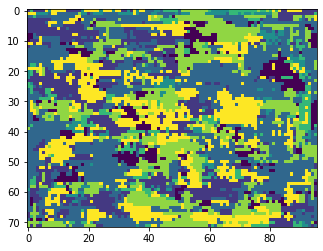

In [66]:
res = np.rot90(categorical_to_img(ouput_numpy), 3)

plt.imshow( res, vmin=0, vmax=len(needed_labels)-1)
plt.show()

In [77]:
minibatch_size = 50
nepoch = 10
learning_rate = 0.001
momentum = 0 
#model = get_model()
#model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#train_generator = DataLoader(train_generator, batch_size=32, num_workers=4, pin_memory=True)
#val_generator = DataLoader(val_generator, batch_size=32, num_workers=4,  pin_memory=True)

for epoch in range(nepoch):
      print(f"training Epoch: {epoch}")
      if epoch > 0:
        train_result = train_one_epoch(model, device, train_generator, optimizer)
        print(f"Result Training dataset {train_result}")

     # eval_result = evaluation(model, device, val_generator)
      #print(f"Result Test dataset {eval_result}")

training Epoch: 0
training Epoch: 1


hello
torch.Size([32, 7, 96, 144])
forward shape entry
torch.Size([32, 7, 96, 144])
forward1
torch.Size([32, 32, 48, 72])
out forward torch.Size([32, 7, 96, 72])
torch.Size([32, 7, 96, 72]) torch.Size([32, 7, 96, 72])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


RuntimeError: ignored

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels=len(needed_labels)):
    dice=0
    for index in range(0, numLabels):                                          
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return numLabels + dice

def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def custom_loss(y_true, y_pred):
    return dice_coef_multilabel(y_true, y_pred) + 5*ssim_loss(y_true, y_pred)

In [ ]:
for epoch in range(nepoch):
      print(f"training Epoch: {epoch}")
      if epoch > 0:
        train_result = train_one_epoch(model, device, train_generator, optimizer)
        print(f"Result Training dataset {train_result}")

      eval_result = evaluation(model, device, val_generator)
      print(f"Result Test dataset {eval_result}")

training Epoch: 0


(1, 96, 144, 7)



TypeError: ignored

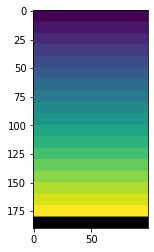

In [72]:
import torch

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Create dummy target image
nb_classes = 19 - 1 # 18 classes + background
idx = np.linspace(0., 1., nb_classes)
cmap = matplotlib.cm.get_cmap('viridis')
rgb = cmap(idx, bytes=True)[:, :3]  # Remove alpha value

h, w = 190, 100
rgb = rgb.repeat(1000, 0)
target = np.zeros((h*w, 3), dtype=np.uint8)
target[:rgb.shape[0]] = rgb
target = target.reshape(h, w, 3)

plt.imshow(target) # Each class in 10 rows

# Create mapping
# Get color codes for dataset (maybe you would have to use more than a single
# image, if it doesn't contain all classes)
target = torch.from_numpy(target)
colors = torch.unique(target.view(-1, target.size(2)), dim=0).numpy()
target = target.permute(2, 0, 1).contiguous()

mapping = {tuple(c): t for c, t in zip(colors.tolist(), range(len(colors)))}

mask = torch.empty(h, w, dtype=torch.long)
for k in mapping:
    # Get all indices for current class
    idx = (target==torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
    validx = (idx.sum(0) == 3)  # Check that all channels match
    mask[validx] = torch.tensor(mapping[k], dtype=torch.long)

print(target.shape)